<a href="https://colab.research.google.com/github/Kurthhenry/Statistics-DataScience/blob/main/EDA_Platypus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This file is showing the Exploratory Data Analysis of group **Platypus**.

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')

In [8]:
directory = "/content/drive/My Drive/Platypus"
merged = pd.read_csv(directory + '/OUT_df/final_df_cleaned.csv', index_col=False)
dfw_merged = pd.read_csv(directory + '/OUT_df/Share_WIP_Cleaned.csv', index_col=False)
dfeps = pd.read_csv(directory + '/OUT_df/EPS_cleaned.csv', index_col=False)

west = ["GRC", "PRT", "FRA", "BEL", "DEN", "ITA", "ESP", "GBR", "NLD", "DEU", "NOR", "TUR"]
east = ["CZE", "POL", "HUN", "SVK", "SVN", "RUS"]

#Univariate Analysis

##Summary Statistics
We first look at the general summary statistics of our variables. Those are the number of observations, the mean, the standard deviation, minimum and maximum values, and the quantiles in between.

In [10]:
#Summary Statistics
#average share of women in parliament
means_WIP = dfw_merged.groupby(dfw_merged["CC"])['WIP'].mean().reset_index()
means_WIP.rename(columns={'WIP': 'Average WIP'}, inplace=True)
means_WIP = means_WIP.sort_values(by='Average WIP', ascending = False)

#average eps score
means_eps = dfeps.groupby(dfeps["CC"])['EPS'].mean().reset_index()
means_eps.rename(columns={'EPS': 'Average EPS'}, inplace=True)
means_eps = means_eps.sort_values(by='Average EPS', ascending = False)

summary_stats = merged.describe()
new_labels = {
    'count': 'Number of Observations',
    'mean': 'Mean',
    'std': 'Standard Deviation',
    'min': 'Minimum Value',
    '25%': '1st Quartile',
    '50%': 'Median',
    '75%': '3rd Quartile',
    'max': 'Maximum Value'
}
summary_stats = summary_stats.rename(index=new_labels)
summary_stats = summary_stats.reset_index()
summary_stats = summary_stats.drop("Year", axis=1)
summary_stats.rename(columns={'index': 'Statistic'}, inplace=True)
summary_stats = summary_stats.round(2)
summary_stats = summary_stats[['Statistic', 'EPS', 'WIP', "Block", "GDPpc", "Education"]]
print(summary_stats)

#table export to LaTeX format -> tbc in Overleaf
latex_ss = summary_stats.to_latex(index=False)
latex_document = r"""
\documentclass{article}
\begin{document}
\begin{table}
\centering
""" + latex_ss + r"""
\caption{Sample table}
\end{table}
\end{document}
"""
with open(directory + '/OUT_tables/table.tex', 'w') as f:
    f.write(latex_document)

                Statistic     EPS     WIP   Block     GDPpc  Education
0  Number of Observations  462.00  483.00  462.00    483.00     483.00
1                    Mean    2.69   26.44    0.27  35534.32      35.39
2      Standard Deviation    0.87   11.31    0.45  13989.95      11.37
3           Minimum Value    0.53    4.18    0.00   7323.44       8.88
4            1st Quartile    2.25   16.67    0.00  26728.10      27.90
5                  Median    2.81   27.39    0.00  33784.45      37.59
6            3rd Quartile    3.22   36.62    1.00  43393.60      43.04
7           Maximum Value    4.89   47.28    1.00  94646.64      62.66


##Disribution of Values

We then look at how those variables are distributed. This is important to investigate whether transformation will be necessary for the later analysis.

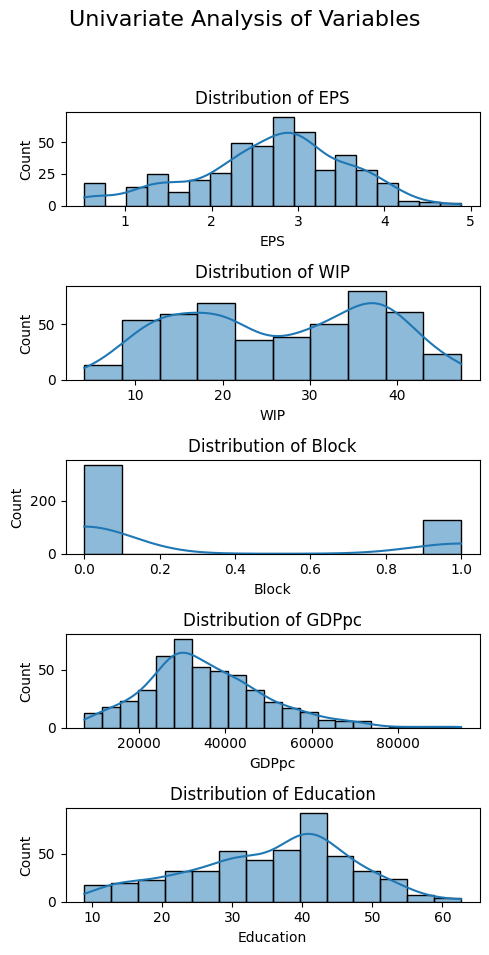

In [18]:
#Visualisation of Summary Statistics
def analyze_variable(data, variable, ax):
    # Summary statistics
    summary = data[variable].describe()
    # Plotting the distribution
    sns.histplot(data[variable], kde=True, ax=ax)
    ax.set_title(f'Distribution of {variable}')
    return summary

# Creating subplots for each of the variables
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(5, 10))
fig.suptitle('Univariate Analysis of Variables', fontsize=16)

# Analyzing each variable
eps_summary = analyze_variable(merged, 'EPS', axes[0])
WIP_summary = analyze_variable(merged, 'WIP', axes[1])
block_summary = analyze_variable(merged, 'Block', axes[2])
gdppc_summary = analyze_variable(merged, 'GDPpc', axes[3])
education_summary = analyze_variable(merged, 'Education', axes[4])

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

#Save Figure
path = "/OUT_plots/Univariate_Key_Variables.pdf"
plt.savefig(directory + path)
plt.show()

We might consider Log-transforming the data for GDP per capita since it is definitely right skewed. However, the rule of thumb is to apply Log-transformation only if the skewness is beyond the range [-3,3].

In [ ]:
skewness = merged['GDPpc'].skew()
print("Skewness: ", skewness)


Skewness:  0.7215980134073005


###Pie Plot of East/West Distribution

We add a pie plot to outline how few observations on eastern countries we have.

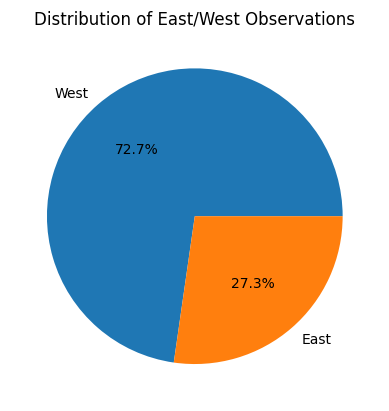

In [21]:
#Pie plot for block distirbution
counts = [sum(merged["Block"] == 0), sum(merged["Block"] == 1)]
plt.pie(counts, labels=['West', 'East'], autopct='%1.1f%%')
plt.title("Distribution of East/West Observations")
path = "/OUT_plots/Pie_Block.pdf"
plt.savefig(directory + path)
plt.show()

#Bivariate Analysis

##Heatmap

A heatmap is a common way to display a correlation table. The table can already give a glimpse on how the variables in our model might behave.

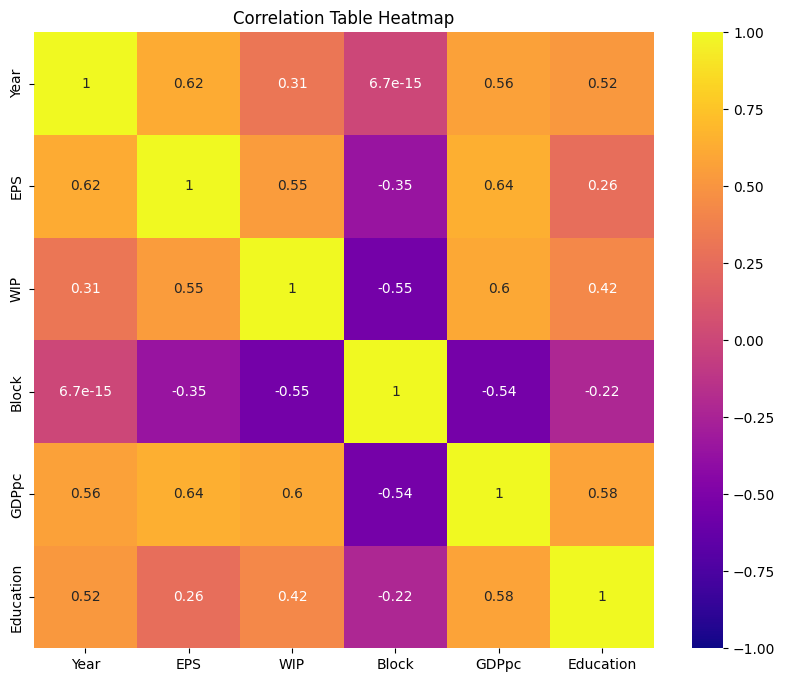

In [19]:
"""Heatmap"""
corr = merged.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='plasma', vmin=-1, vmax=1)
plt.title('Correlation Table Heatmap')
path = "/OUT_plots/Correlation_Heatmap.pdf"
plt.savefig(directory + path)
plt.show()

##Pair Plots

This pair plot specification is structured similarly to a heatmap. It however shows a scatterplot for each of the variable combinations in our model. A regresion line with confidence interval is included for each of the combinations.

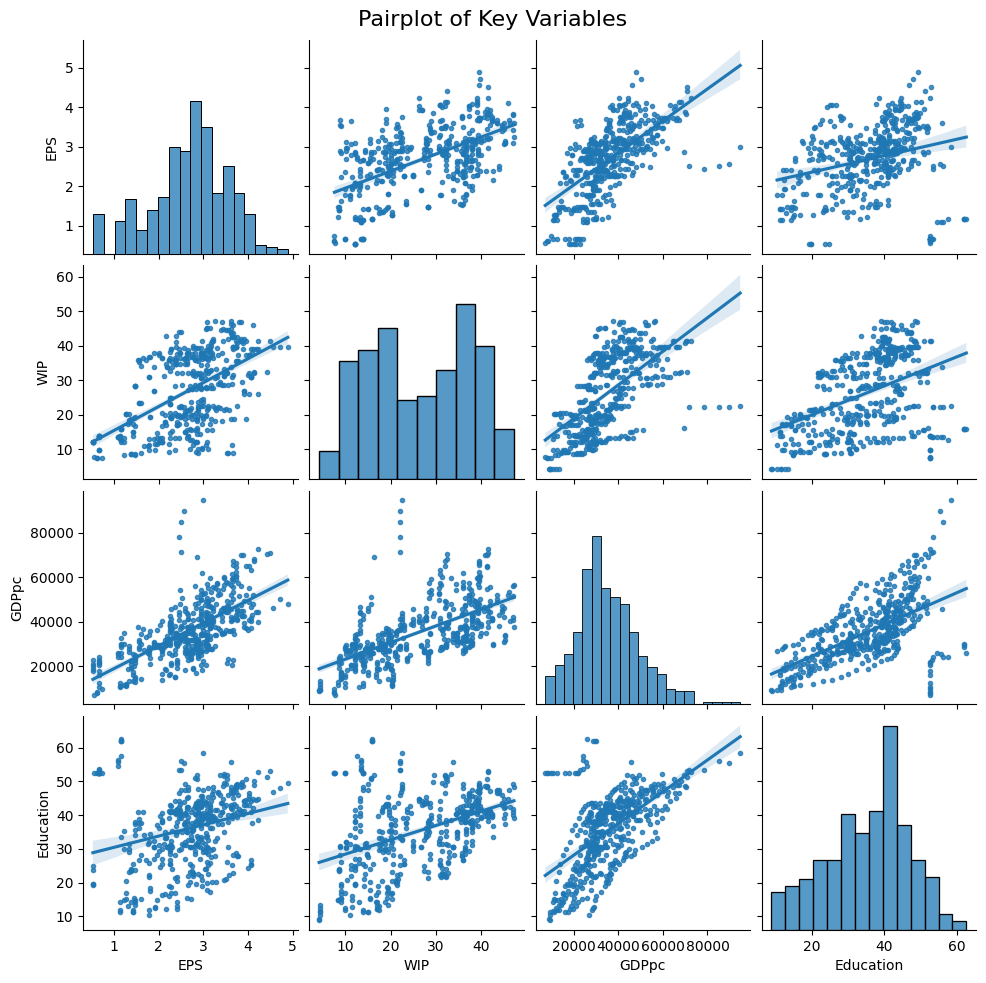

In [20]:
"""Pair Plots"""
# Correlation matrix to understand the relationships between variables
correlation_matrix = merged.corr()

# Pairplot to visualize bivariate relationships
pairplot = sns.pairplot(merged, vars=['EPS', 'WIP', 'GDPpc', 'Education'], kind='reg', markers='.')
pairplot.fig.suptitle('Pairplot of Key Variables', fontsize=16)
plt.subplots_adjust(top=0.95)

# Displaying the correlation matrix
correlation_matrix.style.background_gradient(cmap='coolwarm').set_precision(2)
path = "/OUT_plots/Pairplot_Key_Variables.pdf"
pairplot.savefig(directory + path)

##Scatter Plots

Next we will use scatter plots to identify correlations between the dependent and our independent variables. We thereby always differentiate between block membership to get a grasp of whether this difference in systems could lead to already visible differences in the relationship between dependent and independent variable.

Also, scatterplots can be very useful to identify outliers in the sample! Such outliers are hard to identify without visualizing the data, i.e. by only looking at the tabular representation of values.

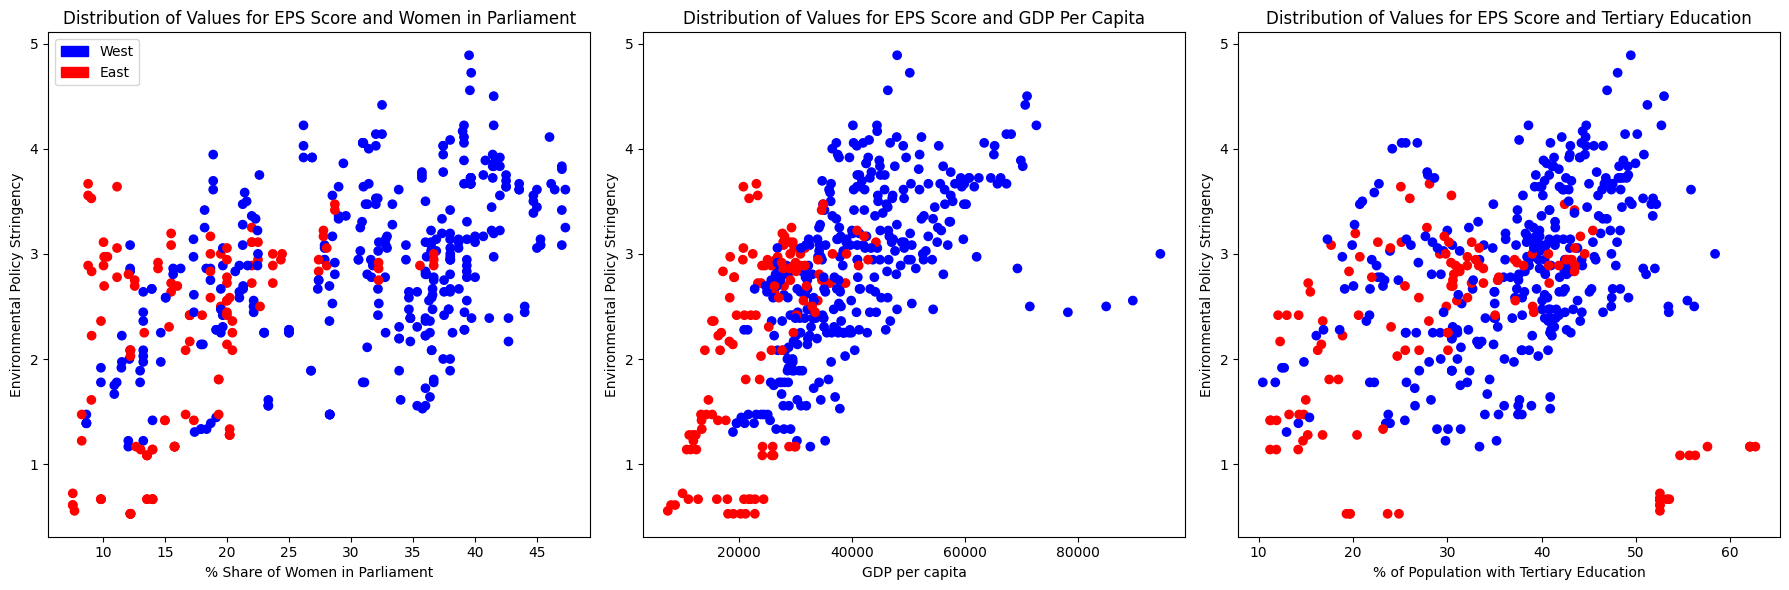

In [22]:
"""Scatter Plots"""
color_map = {0: 'blue', 1: 'red'}
colors = merged['Block'].apply(lambda x: color_map.get(x, 'black'))  # 'black' for any unexpected value

# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Adjust figsize as needed

# Create legend handles
west_patch = mpatches.Patch(color='blue', label='West')
east_patch = mpatches.Patch(color='red', label='East')

# Define the subplots
for i, (col, title) in enumerate(zip(['WIP', 'GDPpc', 'Education'],
                                     ['% Share of Women in Parliament',
                                      'GDP per capita',
                                      '% of Population with Tertiary Education'])):
    slope, intercept = np.polyfit(merged[col], merged['EPS'], 1)
    axes[i].scatter(merged[col], merged['EPS'], c=colors, marker='o')
    y_fit = slope * np.array(merged[col]) + intercept
    axes[i].plot(merged[col], y_fit, color='green')
    axes[i].set_xlabel(title)
    axes[i].set_ylabel('Environmental Policy Stringency')

# Set the titles
titles = ["Distribution of Values for EPS Score and Women in Parliament",
          "Distribution of Values for EPS Score and GDP Per Capita",
          "Distribution of Values for EPS Score and Tertiary Education"]
for ax, title in zip(axes, titles):
    ax.set_title(title)

# Add the legend to the first subplot
axes[0].legend(handles=[west_patch, east_patch], loc="upper left")

# Adjust layout
plt.tight_layout()

# Save the combined plot
path = "/OUT_plots/Scatter_EPS_Combined.pdf"
plt.savefig(directory + path)

# Show the plot
plt.show()


There are clearly outliers to be identified for the education variable. It is important to find out which country exhibits those values. If it is the country of our study, this could be problematic. If these rather linearly low education values are to be attributed to one single country, it would mean that for that country, education is not correlated to the EPS score and with that no endogenous variable.

##Lineplots

To figure out what country could be interesting to use as a treatment or control, we looked at the behaviour of our main variables, EPS score and share of women in parliaments, over time for each object of the sample population. In retrospect, we already know that we take Slovenia for our analysis. That is why we highlighted it in black below. The color grading shows a country's block membership (red=east, blue=west).

We start by looking at the evolution of countries' EPS scores.

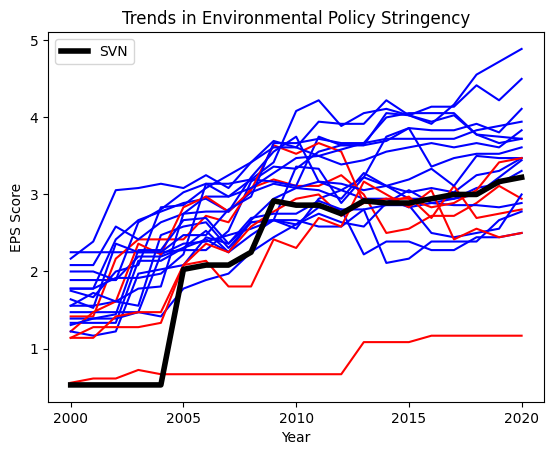

In [25]:
#development of EPS
dfeps_pivot = dfeps.pivot(index='Year', columns='CC', values="EPS")
dfeps_pivot.rename(columns={'EPS': 'Average'}, inplace=True)
highlight_country = 'SVN'
highlight_color = 'black'
ax = plt.gca()  # Get current axis
for country in dfeps_pivot.columns:
    if country == highlight_country:
        dfeps_pivot[country].plot(ax=ax, color=highlight_color, label=country, linewidth=4)
    elif country in east:
        dfeps_pivot[country].plot(ax=ax, color='red', label='_nolegend_')
    elif country in west:
        dfeps_pivot[country].plot(ax=ax, color='blue', label='_nolegend_')
    else:
        dfeps_pivot[country].plot(ax=ax, color='blue', label='_nolegend_')
plt.xticks([2000, 2005, 2010, 2015, 2020])
plt.title("Trends in Environmental Policy Stringency")
plt.ylabel('EPS Score')
plt.xlabel('Year')
#plt.grid(True)
plt.legend()
path = "/OUT_plots/Line_EPS_wHighlight.pdf"
plt.savefig(directory + path)
plt.show()

The same is done for our main independent variable, the share of women in continental European OECD parliaments.

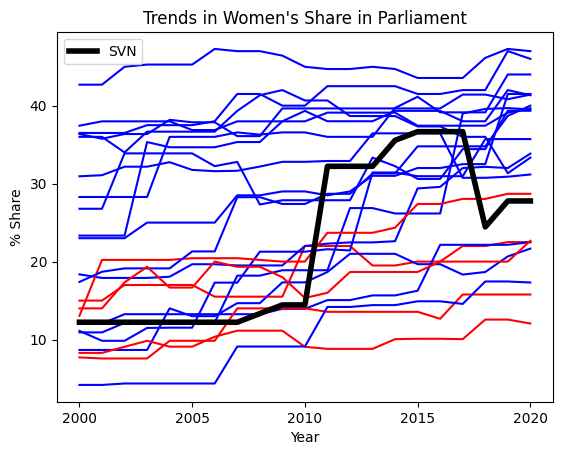

In [26]:
#development of WIP
dfw_pivot = dfw_merged.pivot(index='Year', columns='CC', values="WIP")
dfw_pivot = dfw_pivot.fillna(method='bfill')
dfw_pivot.rename(columns={'WIP': 'Average'}, inplace=True)
highlight_country = 'SVN'
highlight_color = "black"
ax = plt.gca()  # Get current axis
for country in dfw_pivot.columns:
    if country == highlight_country:
        dfw_pivot[country].plot(ax=ax, color=highlight_color, label=country, linewidth=4)
    elif country in east:
        dfw_pivot[country].plot(ax=ax, color='red', label='_nolegend_')
    elif country in west:
        dfw_pivot[country].plot(ax=ax, color='blue', label='_nolegend_')
    else:
        dfw_pivot[country].plot(ax=ax, color='blue', label='_nolegend_')
plt.xticks([2000, 2005, 2010, 2015, 2020])
plt.title("Trends in Women's Share in Parliament")
plt.ylabel('% Share')
plt.xlabel('Year')
#plt.grid(True)
plt.legend()
path = "/OUT_plots/Line_WIP_wHighlight.pdf"
plt.savefig(directory + path)
plt.show()

As we can see above, there is a clear jump in the trajectory of Slovenia in 2010. This is when the government introduced gender quotas for its 2010 elections. We will use this event to study a causal realtionship between the share of women in parliament and a country's EPS score.